# BERT Cased Fine-Tuned on Disability Subset using Toxigen+Hatemoji Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
!pip install -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 37.7 MB/s eta 0:00:00


In [3]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.7 MB/s eta 0:00:00


In [4]:
!pip3 install -q emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import transformers
from transformers import AutoTokenizer,TFBertModel

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Functions and Constants

In [2]:
def to_arrays(df):
  X = df['comment_text'].to_numpy()
  y = df['toxicity_binary'].to_numpy()
  return X, y

def load_data(group):
  df_train = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-train-augmented.csv')
  df_val = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-val-augmented.csv')
  df_test = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-test-augmented.csv')

  X_train, y_train = to_arrays(df_train)
  X_val, y_val = to_arrays(df_val)
  X_test, y_test = to_arrays(df_test)

  return X_train, y_train, X_test, y_test, X_val, y_val

In [3]:
MAX_SEQUENCE_LENGTH = 128

In [4]:
def tokenizing_pipeline(X, tokenizer):
  bert_tokenized = tokenizer(list(X),
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  bert_inputs = [bert_tokenized.input_ids,
                 bert_tokenized.token_type_ids,
                 bert_tokenized.attention_mask]
  return bert_inputs

In [5]:
def build_bertcased_cls_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size=100, 
                          dropout=0.3,
                          learning_rate=0.0001,
                          num_train_layers=0):

    # freeze all pre-trained BERT cased layers
    if num_train_layers == 0:
      bertcased_model.trainable = False

    # partially freeze the first n pre-trained BERT cased layers
    else:
        for layer_num in range(num_train_layers):
            bertcased_model.bert.encoder.layer[layer_num].trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bertcased_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    f1_score = tfa.metrics.F1Score(1, threshold = 0.5)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                                        tf.keras.metrics.Precision(),
                                        tf.keras.metrics.Recall(),
                                        f1_score])

    return classification_model

## Load Data

In [6]:
X_train_disability, y_train_disability, X_test_disability, y_test_disability, X_val_disability, y_val_disability = load_data('disability')

In [7]:
X_train_disability[2]

'Many school related studies focus on the work on children with disabilities in school.\n[6] This article talks about the exceptional children in the classroom and'

In [8]:
X_train_disability[10]

' youre not disabled, you just use a wheelchair'

In [9]:
X_train_disability[20]

' Mental disorders are categorized as psychiatric disorders.Â\xa0- There are more than 180 different types of mental illness.Â\xa0- Serious mental illness is more'

## Load BERT Case Model from_pretrained() **WITHOUT normalization=True**

In [10]:
bertcased_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bertcased_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [11]:
bertcased_tokenizer.tokenize(X_train_disability[1])

['mental', 'disability', 'is', 'extremely', 'physical']

In [12]:
bertcased_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


## Tokenize Data Splits

In [13]:
bertcased_train_inputs_disability = tokenizing_pipeline(X_train_disability, bertcased_tokenizer)
bertcased_test_inputs_disability = tokenizing_pipeline(X_test_disability, bertcased_tokenizer)
bertcased_val_inputs_disability = tokenizing_pipeline(X_val_disability, bertcased_tokenizer)

In [14]:
len(X_train_disability)

24904

In [15]:
len(X_val_disability)

4152

In [16]:
len(X_test_disability)

7265

## Calculate Class Weights for Disability

Get class weights for disability train set:

In [17]:
neg, pos = np.bincount(y_train_disability)
total = neg + pos
print('Disability Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

disability_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Disability Weight for class 0: {:.2f}'.format(weight_for_0))
print('Disability Weight for class 1: {:.2f}'.format(weight_for_1))

Disability Examples:
    Total: 24904
    Positive: 13009 (52.24% of total)

Disability Weight for class 0: 1.05
Disability Weight for class 1: 0.96


## Build Disability Model

In [18]:
num_train_layers=8
learning_rate=1e-6
disability_model = build_bertcased_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
disability_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

In [19]:
num_epochs = 3
batch_size=24
disability_history = disability_model.fit(bertcased_train_inputs_disability,
                                          y_train_disability,
                                          validation_data=(bertcased_val_inputs_disability, y_val_disability),
                                          batch_size=batch_size,
                                          epochs=num_epochs,
                                          class_weight=disability_class_weight)

Epoch 1/3


1038/1038 [==============================] - 95s 75ms/step - loss: 0.5939 - binary_accuracy: 0.6780 - precision: 0.6878 - recall: 0.7025 - f1_score: 0.6951 - val_loss: 0.4960 - val_binary_accuracy: 0.7664 - val_precision: 0.7730 - val_recall: 0.7780 - val_f1_score: 0.7755
Epoch 2/3
1038/1038 [==============================] - 76s 73ms/step - loss: 0.4915 - binary_accuracy: 0.7659 - precision: 0.7769 - recall: 0.7742 - f1_score: 0.7755 - val_loss: 0.4688 - val_binary_accuracy: 0.7830 - val_precision: 0.8118 - val_recall: 0.7571 - val_f1_score: 0.7835
Epoch 3/3
1038/1038 [==============================] - 76s 73ms/step - loss: 0.4651 - binary_accuracy: 0.7802 - precision: 0.7939 - recall: 0.7822 - f1_score: 0.7880 - val_loss: 0.4497 - val_binary_accuracy: 0.7883 - val_precision: 0.7996 - val_recall: 0.7896 - val_f1_score: 0.7946


## Plots

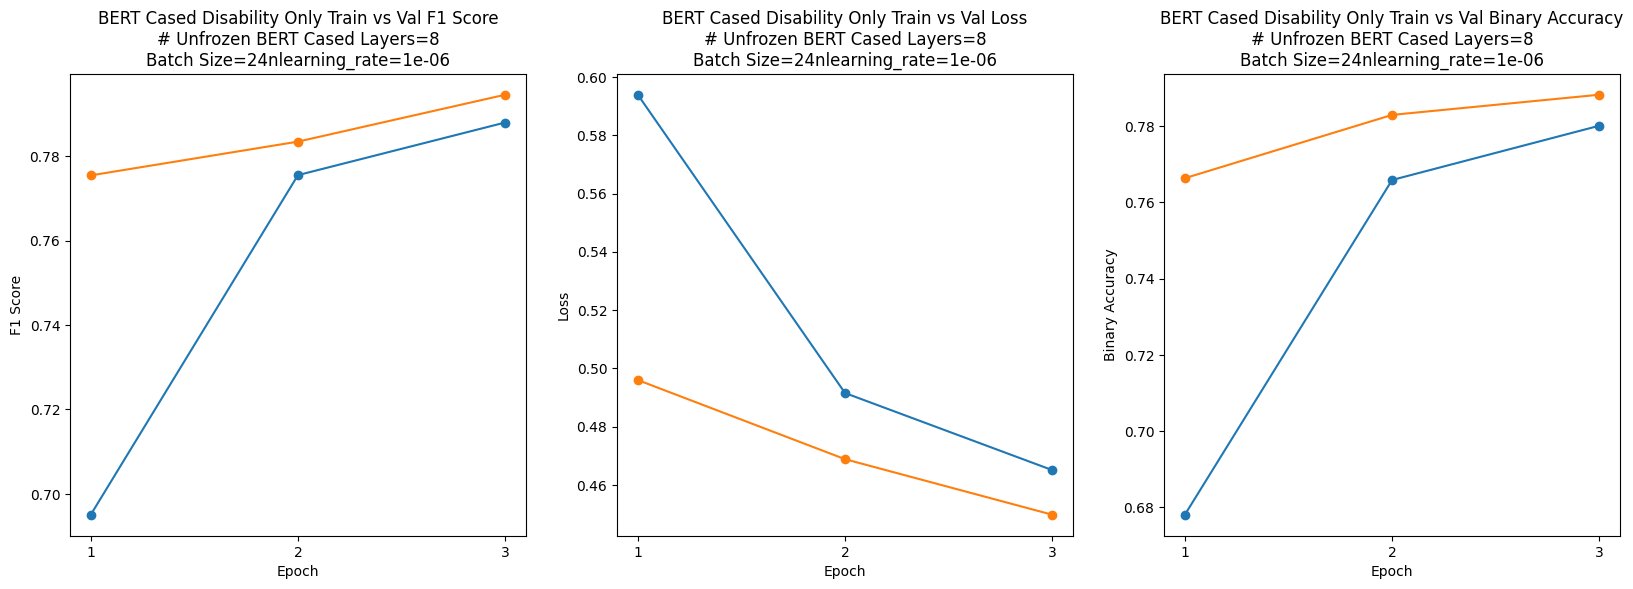

In [20]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(disability_history.history['f1_score'], label="training", marker='o')
axis[0].plot(disability_history.history['val_f1_score'], label="validation", marker='o')
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Epoch')
axis[0].set_xticks(list(range(0, num_epochs)),[str(x) for x in range(1, num_epochs+1)])
axis[0].set_title('BERT Cased Disability Only Train vs Val F1 Score\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Loss
axis[1].plot(disability_history.history['loss'], label="training", marker='o')
axis[1].plot(disability_history.history['val_loss'], label="validation", marker='o')
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Epoch')
axis[1].set_xticks(list(range(0, num_epochs)),[str(x) for x in range(1, num_epochs+1)])
axis[1].set_title('BERT Cased Disability Only Train vs Val Loss\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Binary Accuracy
axis[2].plot(disability_history.history['binary_accuracy'], label="training", marker='o')
axis[2].plot(disability_history.history['val_binary_accuracy'], label="validation", marker='o')
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Epoch')
axis[2].set_xticks(list(range(0, num_epochs)),[str(x) for x in range(1, num_epochs+1)])
axis[2].set_title('BERT Cased Disability Only Train vs Val Binary Accuracy\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

## Save Weights

In [21]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Only_Toxigen_Hatemoji.hdh5')

## Previous Result: We can see that it overfits after 3 epochs, so stop training at 3 epochs

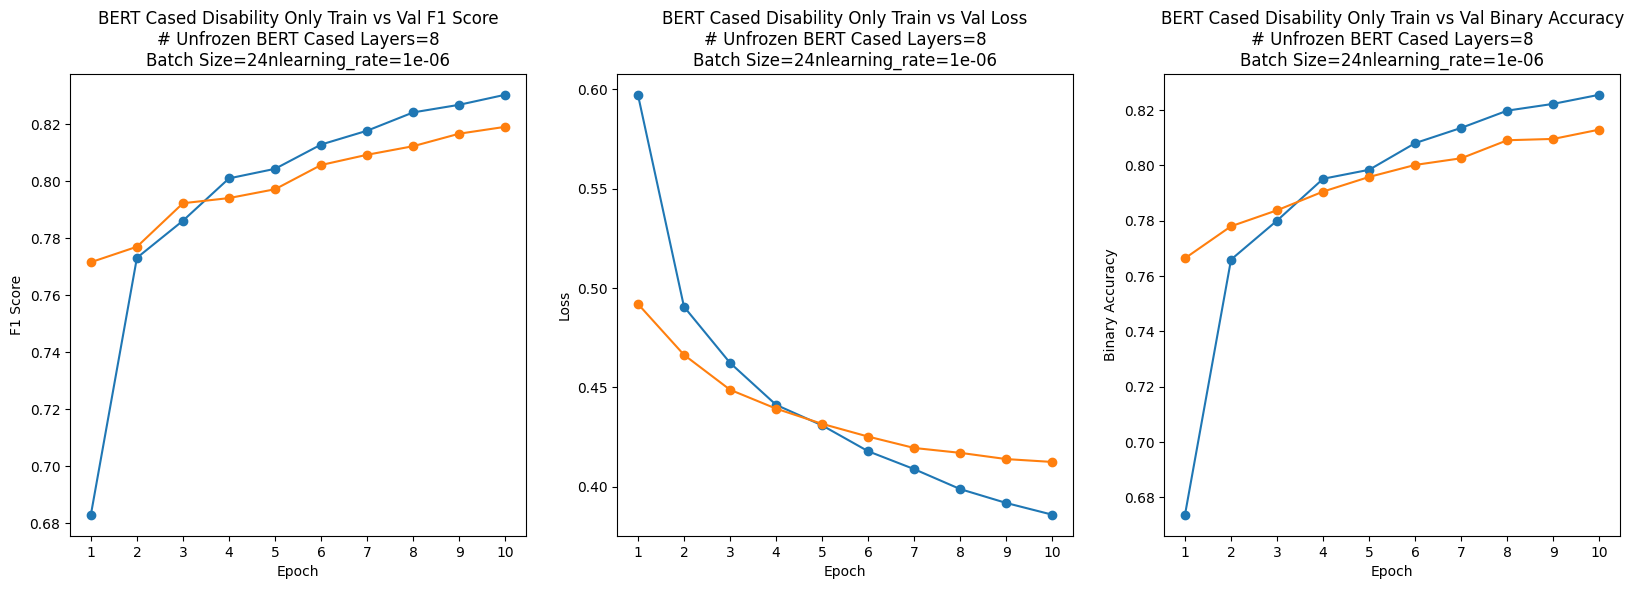